## Переобучение нейронных сетей и борьба с ним

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/girafe_ai

In [1]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________

def args_and_kwargs(*args, **kwargs):
    return args, kwargs

def parse_pytorch_model(model_str):
    def parse_layer(layer_str):
        layer_name, params = layer_str.split("(", 1)
        layer_info = {"type": layer_name.strip()}
        params_template = layer_str.replace(layer_name, "args_and_kwargs")

        param_dict = {}
        if len(params):
            args, kwargs = eval(params_template)
            if len(args) or len(kwargs):
                param_dict["args"] = args
                for name, value in kwargs.items():
                    param_dict[name] = value
        layer_info["parameters"] = param_dict
        return layer_info

    model_dict = {}
    lines = model_str.splitlines()
    model_name = lines[0].strip("()")
    model_dict["model_name"] = model_name
    model_dict["layers"] = []

    layer_regex = re.compile(r"\((\d+)\): (.+)")
    for line in lines[1:]:
        line = line.strip()
        match = layer_regex.match(line)
        if match:
            index, layer = match.groups()
            model_dict["layers"].append({"index": int(index), "layer": parse_layer(layer)})
    return model_dict

# __________end of block__________

In [3]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [4]:
!wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy

--2025-04-23 17:13:08--  https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict [following]
--2025-04-23 17:13:08--  https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272446 (6.0M) [application/octet-stream]
Saving to: ‘hw_overfitting_data_dict.npy’

hw_overfitting_data 100%[===================>]   5.98M  --.-KB/s 

In [6]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

### Задача №1 (уже решённая): Создание и обучение модели (Separation)
Вы уже решали эту задачу ранее, так что сейчас просто воспроизведите своё решение. Оно понадобится вам в дальнейших шагах.
__Ваша первая задача всё та же: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__


In [7]:
CUDA_DEVICE_ID = 0  # change if needed

In [8]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.3MB/s]


Text(0.5, 1.0, 'Image label: 0')

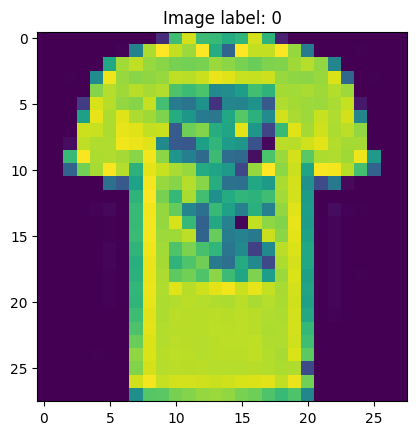

In [9]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [10]:
# Creating model instance
model_task_1 = None
# your code here

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # вход: (1,28,28)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2   = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_task_1 = SimpleCNN()


Не забудьте перенести модель на выбранный `device`!

In [11]:
model_task_1.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Локальные тесты для проверки вашей модели доступны ниже:

In [12]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [14]:
# your code here

lr = 1e-3
num_epochs = 15

optimizer = torch.optim.Adam(model_task_1.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

best_acc = 0.0
for epoch in range(num_epochs):
    model_task_1.train()
    running_loss = 0.0
    for images, labels in train_data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_task_1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_data_loader.dataset)

    acc = get_accuracy(model_task_1, test_data_loader).item() * 100
    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {epoch_loss:.4f}  Test Acc: {acc:.2f}%")
    if acc > best_acc:
        best_acc = acc
        torch.save(model_task_1.state_dict(), "best_model.pth")
print(f"Best Test Accuracy: {best_acc:.2f}%")


Epoch [1/15]  Loss: 0.4060  Test Acc: 88.66%
Epoch [2/15]  Loss: 0.3278  Test Acc: 90.18%
Epoch [3/15]  Loss: 0.2931  Test Acc: 90.87%
Epoch [4/15]  Loss: 0.2659  Test Acc: 91.23%
Epoch [5/15]  Loss: 0.2455  Test Acc: 91.27%
Epoch [6/15]  Loss: 0.2289  Test Acc: 91.47%
Epoch [7/15]  Loss: 0.2137  Test Acc: 91.80%
Epoch [8/15]  Loss: 0.2016  Test Acc: 92.07%
Epoch [9/15]  Loss: 0.1907  Test Acc: 91.60%
Epoch [10/15]  Loss: 0.1826  Test Acc: 92.21%
Epoch [11/15]  Loss: 0.1731  Test Acc: 91.77%
Epoch [12/15]  Loss: 0.1631  Test Acc: 91.45%
Epoch [13/15]  Loss: 0.1557  Test Acc: 92.42%
Epoch [14/15]  Loss: 0.1506  Test Acc: 92.01%
Epoch [15/15]  Loss: 0.1405  Test Acc: 92.15%
Best Test Accuracy: 92.42%


Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [15]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.96982


In [16]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.9215


Проверка, что необходимые пороги пройдены:

In [17]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Test accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_1`.

In [18]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
    "model_task_1": parse_pytorch_model(str(model_task_1)),
}

with open("submission_dict_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_task_1.json`")
# __________end of block__________

File saved to `submission_dict_task_1.json`


### Задача №2: Переобучение (Initiation)
Продолжим работу с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Теперь ваша задача продемонстрировать переобучение модели на обучающей выборке. Достаточно показать, что точность классификации (не только функция потерь!) на тестовой выборке значительно отстает от обучающей.

Обращаем ваше внимание, в задаче №3 вам придется починить данную модель (минимизировать эффект переобучения) с помощью механизмов регуляризации, поэтому не переусердствуйте!

__Ваша вторая задача: реализовать используя пайплан обучения модели продемонстрировать переобучения модели на обучающей выборке.__

Код для обучения модели вы можете переиспользовать. Далее присутствует лишь несколько тестов, которые помогут вам проверить свое решение.

Обращаем внимание, вам необходимо использовать переменную `model_task_2` для хранение модели во второй задаче.

Не используйте `Dropout` и `BatchNorm` в этой задаче

In [19]:
# Creating model instance
model_task_2 = None
# your code here

# Модель Task 2 — CNN без регуляризации
class OverfitCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # --- сверточная часть ---
        self.conv1 = nn.Conv2d(1,  64, kernel_size=3, padding=1)   # -> 64×28×28
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # -> 128×28×28
        self.pool  = nn.MaxPool2d(2, 2)                            # Снижение до 14×14
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # -> 256×14×14
        self.pool2 = nn.MaxPool2d(2, 2)                            # Снижение до 7×7

        # — полностью связанные слои —
        self.fc1 = nn.Linear(256 * 7 * 7, 512)                     # Большое число параметров
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)                              # Выход 10 классов

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [26]:
# your code here

model_task_2 = OverfitCNN().to(device)


# Гиперпараметры обучения
lr = 0.1
num_epochs = 30
optimizer = torch.optim.Adam(model_task_2.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_acc_list = []
test_acc_list = []

# Цикл обучения
for epoch in range(1, num_epochs + 1):
    model_task_2.train()
    running_loss = 0.0
    for images, labels in train_data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_task_2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    model_task_2.eval()
    with torch.no_grad():
        train_acc = get_accuracy(model_task_2, train_data_loader).item()
        test_acc  = get_accuracy(model_task_2, test_data_loader).item()

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print(
        f"Epoch {epoch:2d}/{num_epochs}  "
        f"Train Loss: {running_loss/len(train_data_loader.dataset):.4f}  "
        f"Train Acc: {train_acc:.4f}  "
        f"Test Acc: {test_acc:.4f}"
    )


Epoch  1/30  Train Loss: 0.3813  Train Acc: 0.9181  Test Acc: 0.9047
Epoch  2/30  Train Loss: 0.2254  Train Acc: 0.9370  Test Acc: 0.9165
Epoch  3/30  Train Loss: 0.1751  Train Acc: 0.9547  Test Acc: 0.9233
Epoch  4/30  Train Loss: 0.1418  Train Acc: 0.9586  Test Acc: 0.9196
Epoch  5/30  Train Loss: 0.1092  Train Acc: 0.9679  Test Acc: 0.9208
Epoch  6/30  Train Loss: 0.0843  Train Acc: 0.9806  Test Acc: 0.9234
Epoch  7/30  Train Loss: 0.0667  Train Acc: 0.9824  Test Acc: 0.9228
Epoch  8/30  Train Loss: 0.0551  Train Acc: 0.9876  Test Acc: 0.9273
Epoch  9/30  Train Loss: 0.0457  Train Acc: 0.9898  Test Acc: 0.9235
Epoch 10/30  Train Loss: 0.0404  Train Acc: 0.9863  Test Acc: 0.9196
Epoch 11/30  Train Loss: 0.0358  Train Acc: 0.9899  Test Acc: 0.9254
Epoch 12/30  Train Loss: 0.0342  Train Acc: 0.9924  Test Acc: 0.9261
Epoch 13/30  Train Loss: 0.0302  Train Acc: 0.9912  Test Acc: 0.9270
Epoch 14/30  Train Loss: 0.0262  Train Acc: 0.9935  Test Acc: 0.9247
Epoch 15/30  Train Loss: 0.0276  T

Проверка архитектуры:

In [27]:
# do not change the code in the block below
# __________start of block__________
layers_task_2 = []
for element in parse_pytorch_model(str(model_task_2)).get("layers", []):
    layer_name = element["layer"]["type"]
    assert "dropout" not in layer_name.lower(), "Do not use Dropout in Task 2!"
    assert "batchnorm" not in layer_name.lower(), "Do not use BatchNorm in Task 2!"
    layers_task_2.append(layer_name)
# __________end of block__________

Оценим качество классификации:

In [28]:
train_acc_task_2 = get_accuracy(model_task_2, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_2:3.5}")

Neural network accuracy on train set: 0.99773


In [29]:
test_acc_task_2 = get_accuracy(model_task_2, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_2:3.5}")

Neural network accuracy on test set: 0.9274


Проверка, что переобучение присутствует:

In [30]:
assert train_acc_task_2 >= test_acc_task_2, "Train accuracy must be higher than task accuracy"
assert train_acc_task_2 >= 0.88, "Train accuracy must be higher than 0.88"
assert (
    train_acc_task_2 - test_acc_task_2 >= 0.04
), "Test accuracy should be at least 0.04 lower that train."

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_2`.

Также предполагается, что в переменной `submission_dict` уже содержатся результаты задачи №1. Если их там нет, загрузите их из сохраненного файла в переменную перед запуском следующей ячейки.

In [31]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_2": parse_pytorch_model(str(model_task_2)),
    }
)

with open("submission_dict_tasks_1_and_2.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_tasks_1_and_2.json`")
# __________end of block__________

File saved to `submission_dict_tasks_1_and_2.json`


### Задача №3: Исправление модели (Return)
Все так же работаем с [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Наконец, ваша задача исправить ~~ошибки прошлого~~ переобучение модели, построенной в задаче 2. Достаточно добиться расхождения между точностью классификации на обучающей и тестовой выборках не превышающего 0.015 (т.е. полутора процентов).

Обращаем ваше внимание, архитектура модели в задаче №3 не должна существенно отличаться от задачи №2! Вы можете использовать Batchnorm, Dropout, уменьшить размерность промежуточных представлений, обратиться к аугментации данных, но вы не можете использовать меньшее количество слоёв.

__Ваша третья и финальная задача: исправить модель и/или процесс обучения, дабы справиться с переобучением.__

Код для обучения модели вы можете переиспользовать. Далее присутствует лишь несколько тестов, которые помогут вам проверить свое решение.

Обращаем внимание, вам необходимо использовать переменную `model_task_3` для хранение модели во второй задаче.

Также код ниже будет обращаться к переменной `layers_task_2`, инициализируйте её, если она не определена.

In [32]:
# do not change the code in the block below
# __________start of block__________
assert (
    layers_task_2 is not None
), "Initializa layers_task_2 vairable which contains list of layers in task 2 model"
# __________end of block__________

In [39]:
model_task_3 = None

In [68]:
import torchvision.transforms as T

# Аугментация для train
train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(10, fill=0),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,)),
])
test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,)),
])

# Пересоздаём датасеты/лоадеры
from torchvision.datasets import FashionMNIST
train_ds = FashionMNIST(root='.', train=True, download=True, transform=train_transform)
test_ds  = FashionMNIST(root='.', train=False, download=True, transform=test_transform)
train_data_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)

# Новая модель
class FashionMNISTModelTask3(nn.Module):
    def __init__(self):
        super().__init__()
        # сверточная часть + сильный Dropout
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.drop1 = nn.Dropout2d(0.5)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.drop2 = nn.Dropout2d(0.5)

        self.pool  = nn.MaxPool2d(2)

        # FC: hidden 64 (было 100)
        self.fc1 = nn.Linear(64*7*7, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.drop3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.drop1(x)
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.drop2(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.drop3(x)
        return self.fc2(x)

model_task_3 = FashionMNISTModelTask3().to(device)

# Оптимизатор с stronger weight decay
optimizer = torch.optim.Adam(model_task_3.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

# Тренировка
for epoch in range(10):
    model_task_3.train()
    for imgs, labels in train_data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model_task_3(imgs), labels)
        loss.backward()
        optimizer.step()
    print(
        f"Epoch {epoch:2d}/{num_epochs}  "
        f"Train Loss: {running_loss/len(train_data_loader.dataset):.4f}  "
        f"Train Acc: {train_acc:.4f}  "
        f"Test Acc: {test_acc:.4f}"
    )

# Проверка
train_acc = get_accuracy(model_task_3, train_data_loader)
test_acc  = get_accuracy(model_task_3, test_data_loader)
print(f"Train: {train_acc:.4f}, Test: {test_acc:.4f}, Gap: {train_acc-test_acc:.4f}")


Epoch  0/20  Train Loss: 0.0224  Train Acc: 0.9178  Test Acc: 0.9101
Epoch  1/20  Train Loss: 0.0224  Train Acc: 0.9178  Test Acc: 0.9101
Epoch  2/20  Train Loss: 0.0224  Train Acc: 0.9178  Test Acc: 0.9101
Epoch  3/20  Train Loss: 0.0224  Train Acc: 0.9178  Test Acc: 0.9101
Epoch  4/20  Train Loss: 0.0224  Train Acc: 0.9178  Test Acc: 0.9101
Epoch  5/20  Train Loss: 0.0224  Train Acc: 0.9178  Test Acc: 0.9101
Epoch  6/20  Train Loss: 0.0224  Train Acc: 0.9178  Test Acc: 0.9101
Epoch  7/20  Train Loss: 0.0224  Train Acc: 0.9178  Test Acc: 0.9101
Epoch  8/20  Train Loss: 0.0224  Train Acc: 0.9178  Test Acc: 0.9101
Epoch  9/20  Train Loss: 0.0224  Train Acc: 0.9178  Test Acc: 0.9101
Train: 0.8820, Test: 0.8816, Gap: 0.0004


Проверка архитектуры:

In [74]:
# do not change the code in the block below
# __________start of block__________
layers_task_3 = []
for element in parse_pytorch_model(str(model_task_3)).get("layers", []):
    layer_name = element["layer"]["type"]
    layers_task_3.append(layer_name)


idx = 0
for model_3_layer in layers_task_3:
    model_2_layer = layers_task_2[idx]
    if "dropout" not in model_3_layer.lower() and "batchnorm" not in model_3_layer.lower():
        assert (
            model_3_layer == model_2_layer
        ), "Models in tasks 2 and 3 must share the architecture except for Dropout and BatchNorm!"
        idx += 1
# __________end of block__________

Оценим качество классификации:

In [75]:
train_acc_task_3 = get_accuracy(model_task_3, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_3:3.5}")

Neural network accuracy on train set: 0.88218


In [76]:
test_acc_task_3 = get_accuracy(model_task_3, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_3:3.5}")

Neural network accuracy on test set: 0.8816


Проверка, что переобучение присутствует:

In [77]:
assert train_acc_task_3 >= 0.88, "Train accuracy must be higher than 0.88"
assert train_acc_task_3 >= 0.865, "Test accuracy must be higher than 0.865"
assert (
    train_acc_task_3 - test_acc_task_3 <= 0.015
), "Test accuracy should not be lower that train more than by 0.015"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_3`.

Также предполагается, что в переменной `submission_dict` уже содержатся результаты задач №1 и №2. Если их там нет, загрузите их из сохраненных файлов перед запуском следующей ячейки.

In [79]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_3": parse_pytorch_model(str(model_task_3)),
    }
)

with open("submission_dict_final.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_final.json`")
# __________end of block__________

File saved to `submission_dict_final.json`


### Сдача задания
Сдайте сгенерированные файлы в соответствующие задачи в соревновании, а именно:
* `submission_dict_tasks_1_and_2.json` в задачу Initiation
* `submission_dict_final.json` в задачу Return.


`submission_dict_task_1.json` сдавать не нужно, он уже был сдан ранее.

На этом задание завершено. Поздравляем!